In [2]:
library(rugarch)
library(readxl)
library(writexl)
library(zoo)
library(parallel)
library(doParallel)
library(foreach)
library(iterators)

In [3]:
data <- read_excel("all_data/returns.xlsx")
data$sp_500 <- NULL
dates <- as.Date(data$Date)

stock_names <- colnames(data)[colnames(data) != "Date"]

# Filter data from 2012-01-01 onwards
data_2012 <- data[dates >= as.Date("2012-01-01"), ]
dates_2012 <- dates[dates >= as.Date("2012-01-01")]

# Create dataframe for realized volatility
all_realized_vol <- data.frame(Date = dates_2012)

In [4]:
# For each stock: convert returns to log returns, then calculate absolute value or squared
for(stock in stock_names) {
  
  returns <- data_2012[[stock]]
  
  # Convert to log returns: log(1 + return)
  log_returns <- log(1 + returns)
  
  # Realized volatility = absolute value of log returns (or use log_returns^2 for squared)
  realized_vol <- abs(log_returns)
  
  # Add to dataframe
  all_realized_vol[[stock]] <- realized_vol
}

In [6]:
# Save if needed
write_xlsx(all_realized_vol, "all_data/realized_volatility.xlsx")

#### **GARCH**

In [4]:
# Setup parallel processing
cl <- makeCluster(5)
registerDoParallel(cl)

stock_names <- colnames(data)[colnames(data) != "Date"]

clusterExport(cl, c("data", "dates", "stock_names"))
clusterEvalQ(cl, {
  library(rugarch)
})

# Parallel loop returns list of results per stock
all_garch_list <- foreach(stock = stock_names, .packages = "rugarch") %dopar% {
  
  log_returns <- data[[stock]]
  
  valid_indices <- !is.na(log_returns)
  log_returns_clean <- log_returns[valid_indices]
  dates_clean <- dates[valid_indices]
  
  start_2012_index <- which(dates_clean >= as.Date("2012-01-01"))[1]
  window_size <- start_2012_index - 1
  forecast_length <- length(log_returns_clean) - window_size
  
  garch_spec <- ugarchspec(
    variance.model = list(model = "sGARCH", garchOrder = c(1, 1)),
    mean.model = list(armaOrder = c(0, 0), include.mean = TRUE),
    distribution.model = "norm"
  )
  
  garch_roll <- ugarchroll(
    spec = garch_spec,
    data = log_returns_clean,
    n.ahead = 1,
    forecast.length = forecast_length,
    refit.every = 1,
    refit.window = "moving",
    window.size = window_size
  )
  
  forecasted_vol <- as.data.frame(garch_roll)$Sigma
  forecast_dates <- dates_clean[start_2012_index:length(dates_clean)]
  
  # Return as dataframe with stock name as column
  temp_df <- data.frame(
    Date = forecast_dates,
    vol = forecasted_vol
  )
  colnames(temp_df)[2] <- stock
  
  return(temp_df)
}

stopCluster(cl)

# Combine into wide format
all_garch_results <- all_garch_list[[1]]
for(i in 2:length(all_garch_list)) {
  all_garch_results <- merge(all_garch_results, all_garch_list[[i]], by = "Date", all = TRUE)
}

# Export results
write_xlsx(all_garch_results, "all_data/garch_volatility_forecasts.xlsx")

cat("\n========================================\n")
cat("GARCH COMPLETED!\n")
cat("Format: Wide format (Date + one column per stock)\n")
cat("Total stocks processed:", length(stock_names), "\n")
cat("Dimensions:", nrow(all_garch_results), "rows x", ncol(all_garch_results), "columns\n")
cat("Results saved to: all_data/garch_volatility_forecasts.xlsx\n")
cat("========================================\n")

[[1]]
[1] "rugarch"   "parallel"  "stats"     "graphics"  "grDevices" "utils"    
[7] "datasets"  "methods"   "base"     

[[2]]
[1] "rugarch"   "parallel"  "stats"     "graphics"  "grDevices" "utils"    
[7] "datasets"  "methods"   "base"     

[[3]]
[1] "rugarch"   "parallel"  "stats"     "graphics"  "grDevices" "utils"    
[7] "datasets"  "methods"   "base"     

[[4]]
[1] "rugarch"   "parallel"  "stats"     "graphics"  "grDevices" "utils"    
[7] "datasets"  "methods"   "base"     

[[5]]
[1] "rugarch"   "parallel"  "stats"     "graphics"  "grDevices" "utils"    
[7] "datasets"  "methods"   "base"


GARCH COMPLETED!
Format: Wide format (Date + one column per stock)
Total stocks processed: 45 
Dimensions: 3455 rows x 46 columns
Results saved to: all_data/garch_volatility_forecasts.xlsx


# **VALIDATION**

In [7]:
library(rugarch)
library(readxl)
library(writexl)
library(zoo)
library(parallel)
library(doParallel)
library(foreach)
library(iterators)
library(forecast)

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



In [8]:
hist_vol <- read_excel("all_data/realized_volatility.xlsx")
garch_vol <- read_excel("all_data/garch_volatility_forecasts.xlsx")

# Compact information
cat("Historical Volatility:", nrow(hist_vol), "rows,", ncol(hist_vol), "columns\n")
cat("GARCH Volatility:", nrow(garch_vol), "rows,", ncol(garch_vol), "columns\n")

# Check column names
colnames(hist_vol)
colnames(garch_vol)

# Check for missing values
sum(is.na(hist_vol))
sum(is.na(garch_vol))

# Verify they all have the same columns now
cat("Historical Volatility:", nrow(hist_vol), "rows,", ncol(hist_vol), "columns\n")
cat("GARCH Volatility:", nrow(garch_vol), "rows,", ncol(garch_vol), "columns\n")

# Check they have the same column names
all(colnames(hist_vol) == colnames(garch_vol))
head(hist_vol, 2)
head(garch_vol, 2)

Historical Volatility: 3455 rows, 46 columns
GARCH Volatility: 3455 rows, 46 columns


[1] "Date"  "AAPL"  "ABT"   "AMD"   "AMZN"  "AVGO"  "AXP"   "BAC"   "BRK-B"
[10] "CAT"   "COST"  "CRM"   "CSCO"  "CVX"   "DIS"   "GE"    "GOOG"  "GOOGL"
[19] "GS"    "HD"    "IBM"   "JNJ"   "JPM"   "KO"    "LLY"   "LRCX"  "MA"   
[28] "MCD"   "MRK"   "MS"    "MSFT"  "MU"    "NFLX"  "NVDA"  "ORCL"  "PG"   
[37] "PM"    "QCOM"  "RTX"   "TMO"   "TMUS"  "UNH"   "V"     "WFC"   "WMT"  
[46] "XOM"

[1] "Date"  "AAPL"  "ABT"   "AMD"   "AMZN"  "AVGO"  "AXP"   "BAC"   "BRK-B"
[10] "CAT"   "COST"  "CRM"   "CSCO"  "CVX"   "DIS"   "GE"    "GOOG"  "GOOGL"
[19] "GS"    "HD"    "IBM"   "JNJ"   "JPM"   "KO"    "LLY"   "LRCX"  "MA"   
[28] "MCD"   "MRK"   "MS"    "MSFT"  "MU"    "NFLX"  "NVDA"  "ORCL"  "PG"   
[37] "PM"    "QCOM"  "RTX"   "TMO"   "TMUS"  "UNH"   "V"     "WFC"   "WMT"  
[46] "XOM"

[1] 0

[1] 0

Historical Volatility: 3455 rows, 46 columns
GARCH Volatility: 3455 rows, 46 columns


[1] TRUE

Date,AAPL,ABT,AMD,AMZN,AVGO,AXP,BAC,BRK-B,CAT,⋯,PM,QCOM,RTX,TMO,TMUS,UNH,V,WFC,WMT,XOM
<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2012-01-03,0.015265893,0.008676580,0.014706133,0.033683951,0.003113435,0.0255351255,0.042259230,0.01792485,0.03662832,⋯,0.001400456,0.01036676,0.021252658,0.04202197,0.07862364,0.01585635,0.01427719,0.031079349,0.009493449,0.0145236063
2012-01-04,0.005359639,0.003886733,0.003656308,0.008526468,0.017421531,0.0006223001,0.001723052,0.01139315,0.00921396,⋯,0.001782612,0.01008089,0.005210258,0.02046366,0.06603062,0.01446086,0.01802753,0.004562159,0.010330031,0.0002325183


Date,AAPL,ABT,AMD,AMZN,AVGO,AXP,BAC,BRK-B,CAT,⋯,PM,QCOM,RTX,TMO,TMUS,UNH,V,WFC,WMT,XOM
<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2012-01-03,0.01345769,0.008226445,0.03202189,0.02387973,0.02408681,0.01647823,0.02960131,0.01140869,0.02100649,⋯,0.01086566,0.01796090,0.01548734,0.01713479,0.03012443,0.01555758,0.01937312,0.02124962,0.007950617,0.01312813
2012-01-04,0.01376482,0.008350544,0.03089721,0.02445994,0.02329539,0.01780466,0.03208644,0.01316684,0.02283561,⋯,0.01051155,0.01788348,0.01607610,0.02084724,0.03843199,0.01584831,0.01849415,0.02228435,0.008473964,0.01319539


In [9]:
# Function to calculate all error metrics
calculate_errors <- function(forecasted_vol, realized_vol) {
  
  # Remove NA values
  valid_indices <- !is.na(forecasted_vol) & !is.na(realized_vol)
  forecasted_vol <- forecasted_vol[valid_indices]
  realized_vol <- realized_vol[valid_indices]
  
  # Calculate errors
  mae <- mean(abs(realized_vol - forecasted_vol))
  rmse <- sqrt(mean((realized_vol - forecasted_vol)^2))
  qlike <- mean(realized_vol/forecasted_vol - log(realized_vol/forecasted_vol) - 1)
  
  # Return as a list
  return(list(MAE = mae, RMSE = rmse, QLIKE = qlike))
}


# To apply to ALL columns at once:
calculate_all_stocks <- function(vol_data, realized_data) {
  
  stock_names <- colnames(vol_data)[colnames(vol_data) != "Date"]
  
  results <- data.frame(
    Stock = character(),
    MAE = numeric(),
    RMSE = numeric(),
    QLIKE = numeric(),
    stringsAsFactors = FALSE
  )
  
  for(stock in stock_names) {
    errors <- calculate_errors(vol_data[[stock]], realized_data[[stock]])
    results <- rbind(results, data.frame(
      Stock = stock,
      MAE = errors$MAE,
      RMSE = errors$RMSE,
      QLIKE = errors$QLIKE
    ))
  }
  
  return(results)
}

In [10]:
# FIXED: Use calculate_all_stocks instead of calculate_errors
garch_results <- calculate_all_stocks(garch_vol, hist_vol)
print(garch_results)

   Stock         MAE        RMSE    QLIKE
1   AAPL 0.010196078 0.013367009      Inf
2    ABT 0.007719410 0.010114400      Inf
3    AMD 0.021496347 0.027718181      Inf
4   AMZN 0.011813372 0.015710248      Inf
5   AVGO 0.013347076 0.017733626      Inf
6    AXP 0.009573622 0.013376681      Inf
7    BAC 0.010555566 0.013667288      Inf
8  BRK-B 0.006107469 0.008182441      Inf
9    CAT 0.010197780 0.013000916      Inf
10  COST 0.007383549 0.009807214      Inf
11   CRM 0.012955273 0.017254355      Inf
12  CSCO 0.009292527 0.012511649      Inf
13   CVX 0.008610828 0.012301172      Inf
14   DIS 0.009248636 0.012655451      Inf
15    GE 0.010768939 0.014557872      Inf
16  GOOG 0.010091810 0.013256015 0.564518
17 GOOGL 0.010055367 0.013188030      Inf
18    GS 0.009599798 0.012567071      Inf
19    HD 0.007740848 0.010374292      Inf
20   IBM 0.008244346 0.011273087      Inf
21   JNJ 0.005965118 0.007858968      Inf
22   JPM 0.008919298 0.011866318      Inf
23    KO 0.005891403 0.007823494  

In [11]:
library(forecast)

# Function to perform DM test: GARCH vs Historical Rolling SD
dm_test_all_stocks <- function(garch_forecast, historical_rolling_sd) {
  
  stock_names <- colnames(garch_forecast)[colnames(garch_forecast) != "Date"]
  
  results <- data.frame(
    Stock = character(),
    DM_Statistic = numeric(),
    P_Value = numeric(),
    Better_Model = character(),
    stringsAsFactors = FALSE
  )
  
  for(stock in stock_names) {
    
    # Get the forecasts from both methods
    garch_f <- garch_forecast[[stock]]
    hist_f <- historical_rolling_sd[[stock]]
    
    # Remove NAs
    valid_indices <- !is.na(garch_f) & !is.na(hist_f)
    garch_f <- garch_f[valid_indices]
    hist_f <- hist_f[valid_indices]
    
    # For DM test, we need the actual realized volatility (next period)
    # Shift hist_f forward by 1 to get the "true" next period volatility
    actual_vol <- c(hist_f[-1], NA)
    actual_vol <- actual_vol[!is.na(actual_vol)]
    garch_f <- garch_f[1:length(actual_vol)]
    hist_f <- hist_f[1:length(actual_vol)]
    
    # Calculate squared forecast errors
    error_garch <- (actual_vol - garch_f)^2
    error_hist <- (actual_vol - hist_f)^2
    
    # Perform DM test
    dm_result <- dm.test(error_garch, error_hist, alternative = "two.sided")
    
    # Determine better model
    if(dm_result$p.value < 0.05) {
      better <- ifelse(dm_result$statistic < 0, "GARCH", "Historical_SD")
    } else {
      better <- "No_Difference"
    }
    
    results <- rbind(results, data.frame(
      Stock = stock,
      DM_Statistic = as.numeric(dm_result$statistic),
      P_Value = dm_result$p.value,
      Better_Model = better
    ))
  }
  
  return(results)
}

# Run the test
dm_results <- dm_test_all_stocks(garch_vol, hist_vol)
print(dm_results)

# Summary
cat("\nSummary:\n")
cat("GARCH is better:", sum(dm_results$Better_Model == "GARCH"), "stocks\n")
cat("Historical SD is better:", sum(dm_results$Better_Model == "Historical_SD"), "stocks\n")
cat("No significant difference:", sum(dm_results$Better_Model == "No_Difference"), "stocks\n")

     Stock DM_Statistic      P_Value  Better_Model
DM    AAPL   -4.4271125 9.845925e-06         GARCH
DM1    ABT   -4.6064587 4.243762e-06         GARCH
DM2    AMD   -3.2922833 1.003777e-03         GARCH
DM3   AMZN   -3.6694610 2.467343e-04         GARCH
DM4   AVGO   -3.7259368 1.977054e-04         GARCH
DM5    AXP   -2.4674126 1.365751e-02         GARCH
DM6    BAC   -2.3048540 2.123379e-02         GARCH
DM7  BRK-B   -1.9617642 4.987016e-02         GARCH
DM8    CAT   -3.5737366 3.567357e-04         GARCH
DM9   COST   -2.7287163 6.390344e-03         GARCH
DM10   CRM   -1.7990554 7.209719e-02 No_Difference
DM11  CSCO   -3.0924157 2.001200e-03         GARCH
DM12   CVX   -1.8935109 5.837349e-02 No_Difference
DM13   DIS   -4.3914944 1.159518e-05         GARCH
DM14    GE   -3.9209759 8.990397e-05         GARCH
DM15  GOOG   -2.8495115 4.404577e-03         GARCH
DM16 GOOGL   -2.6366641 8.410067e-03         GARCH
DM17    GS   -2.2182780 2.660070e-02         GARCH
DM18    HD   -1.1493437 2.50493

Date,AAPL,ABT
<dttm>,<dbl>,<dbl>
2012-01-03,0.01345769,0.008226445
2012-01-04,0.01376482,0.008350544
2012-01-05,0.01331411,0.008144099
2012-01-06,0.01322205,0.007893840
2012-01-09,0.01310301,0.008210792
2012-01-10,0.01277758,0.007910368
2012-01-11,0.01240223,0.007766158
2012-01-12,0.01215956,0.007634344
2012-01-13,0.01199936,0.007574668


Date,AAPL,ABT
<dttm>,<dbl>,<dbl>
2012-01-03,0.015265893,0.0086765798
2012-01-04,0.005359639,0.0038867327
2012-01-05,0.011040743,0.0023030929
2012-01-06,0.010399721,0.0090884851
2012-01-09,0.001587696,0.0001786166
2012-01-10,0.003574295,0.0046439108
2012-01-11,0.001631455,0.0037818178
2012-01-12,0.002749320,0.0047022883
2012-01-13,0.003756177,0.0048826324


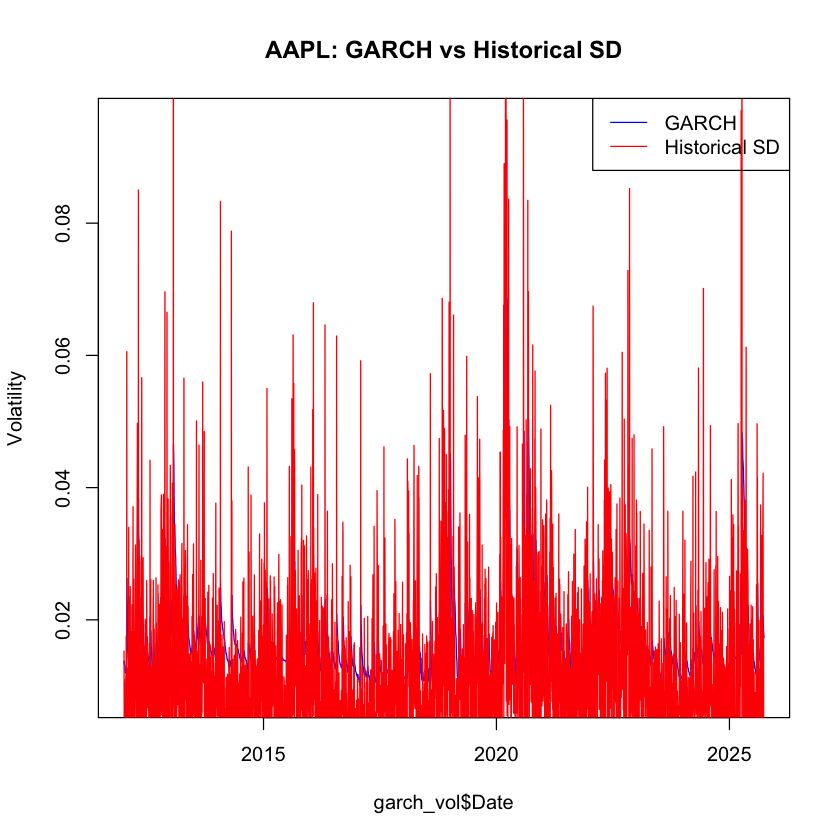

In [12]:
# Check first 10 rows
head(garch_vol[, 1:3], 10)
head(hist_vol[, 1:3], 10)

# Plot comparison for AAPL
plot(garch_vol$Date, garch_vol$AAPL, type="l", col="blue", 
     main="AAPL: GARCH vs Historical SD", ylab="Volatility")
lines(hist_vol$Date, hist_vol$AAPL, col="red")
legend("topright", c("GARCH", "Historical SD"), col=c("blue", "red"), lty=1)